# WRF model wind speed calculations and visualization

- [High Resolution WRF Simulations of the Current and Future Climate of North America](https://rda.ucar.edu/datasets/ds612.0/index.html#sfol-wl-/data/ds612.0?g=33200406) (DOI: 10.5065/D6V40SXP)
- For example, Research Data Archive (RDA) data set https://rda.ucar.edu/data/ds612.0/PGW3D/2004/wrf3d_d01_PGW_U_20040602.nc (careful to click, big download!)
- Can take a long time to calculate due to volume of data. **How can we speed up calculations in this Jupyter Notebook?**

# Summary / Outline

- What is Dask?
- Set up our cluster
- Run "positive control experiment" to ensure cluster is running
- Run notebooks analyzing and visualizing wind speed data from UCAR RDA
- Future work

# Dask

- Dask is a Python library for parallel and distributed computing
- "Lazy" loading of larger-than-memory datasets
- "HPC in the client or HPC in the notebook"
- Tries to hide messy details of parallel computation (though may still have to think about chunking, etc.)
- Beyond Jupyter, we'll use the following technologies for our Dask cluster on the NSF Jetstream Cloud:

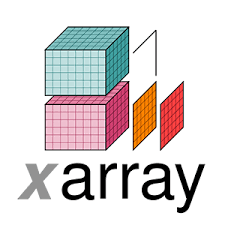 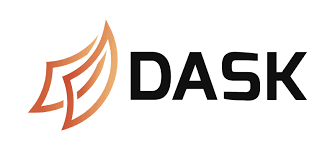 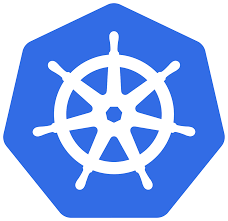

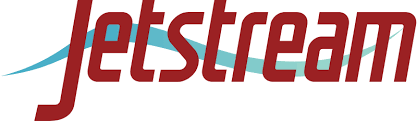

# Set up 

- Xarray / Dask / Kubernetes allows for fast parallelization 
- [Must be very careful to coordinate worker / client / scheduler conda environments](https://github.com/julienchastang/jupyter-classroom/tree/master/rut-spring-2022)
- Setup for Dask cluster:
  - 4 workers
  - 4 cores per worker
  - 8 GBs per worker
  - 16 “task streams”

Our imports. `ProgressBar` will display the progress of our Dask calculations in the Dask dashboard

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import dask_gateway, dask, distributed, time
from dask.diagnostics import ProgressBar

Baseline time to determine how long it takes for this notebook to run.

In [2]:
time0 = time.time()

Lengthy timeouts are apparently important.

In [3]:
dask.config.set({"distributed.comm.timeouts.tcp": "300s"})
dask.config.set({"distributed.comm.timeouts.connect": "300s"})

Creating the cluster gateway that will give us access to our cluster.

In [4]:
from dask_gateway import Gateway
gateway = Gateway(
    address="http://traefik-dask-gateway/services/dask-gateway/",
    public_address="https://js-156-66.jetstream-cloud.org/services/dask-gateway/",
    auth="jupyterhub")
gateway

Gateway<http://traefik-dask-gateway/services/dask-gateway>

Let's examine the default cluster options:

In [5]:
options = gateway.cluster_options()
options

Launching cluster. This might take a few minutes. Make a note of the Dask Dashboard URL. Open it in a separate tab. The URL should look something like:

```
https://js-156-66.jetstream-cloud.org/services/dask-gateway/clusters/jhub.231b3db17f834c2e92130c5dde31c346/status
```

Make sure the first part of the URL matches what you see for the URL of this page. **IMPORTANT**: Only call this cell once or else you will have multiple clusters on your hands that you will have to sort through.

In [6]:
cluster = gateway.new_cluster(options)
cluster.scale(4)
cluster

You only have **one** cluster, right?

In [7]:
clusters = gateway.list_clusters()
clusters

[ClusterReport<name=jhub.fd9bfa4aba6d4cd58bf3477046d65356, status=RUNNING>]

Grab first, cluster. (There should not be more than one anyway.)

In [8]:
cluster = gateway.connect(clusters[0].name)

Don't forget to call or else cluster will apparently die. 

In [9]:
client = cluster.get_client()
client

Client Scheduler: gateway://traefik-dask-gateway:80/jhub.fd9bfa4aba6d4cd58bf3477046d65356 Dashboard: http://traefik-dask-gateway/services/dask-gateway/clusters/jhub.fd9bfa4aba6d4cd58bf3477046d65356/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Apparently important if you want to see Dask Dashboard update.

In [10]:
client = gateway.connect(cluster.name).get_client()

## Control "Experiment"

This is a "positive control experiment" to ensure the cluster is working with this "embarrassingly parallel" calculation. Make sure the dashboard "task stream" is also working.

In [11]:
import dask.array as da
a = da.random.normal(size=(40000, 40000), chunks=(500, 500))
a.mean().compute()

9.242190249763211e-06

-------------

## Now run notebook in earnest

Now you are ready to run your notebook in earnest. Let's first define an `unstagger` function to unstagger the WRF grid.

In [12]:
def unstagger(ds, var, coord, new_coord):
    var1 = ds[var].isel({coord: slice(None, -1)})
    var2 = ds[var].isel({coord: slice(1, None)})
    return ((var1 + var2) / 2).rename({coord: new_coord})

Let's start grabbing data from an

Open U dataset from the RDA THREDDS catalog

In [13]:
ds = xr.open_dataset('https://rda.ucar.edu/thredds/dodsC/files/g/ds612.0/PGW3D/2004/wrf3d_d01_PGW_U_20040601.nc',
                      chunks={'bottom_top': 10})

Plot unstaggered surface **U** winds. Theoretically, should be able to examine the progress in the Dask Dashboard below the task stream.

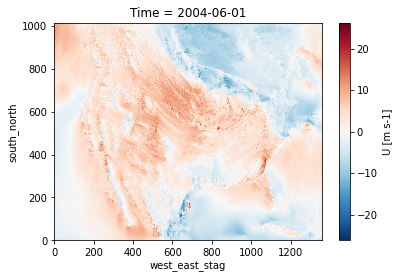

In [14]:
with ProgressBar():
    ds.U.sel(Time='2004-06-01T00:00').isel(bottom_top=0).plot()

Unstagger U grid

In [15]:
with ProgressBar():
    ds['U_unstaggered'] = unstagger(ds, 'U', 'west_east_stag', 'west_east')

Open V dataset

In [16]:
ds2 = xr.open_dataset('https://rda.ucar.edu/thredds/dodsC/files/g/ds612.0/PGW3D/2004/wrf3d_d01_PGW_V_20040601.nc',
                      chunks={'bottom_top': 10})
ds2

<xarray.Dataset>
Dimensions:   (south_north: 1015, west_east: 1359, Time: 8, bottom_top: 50,
               south_north_stag: 1016)
Coordinates:
  * Time      (Time) datetime64[ns] 2004-06-01 ... 2004-06-01T21:00:00
    XLAT_V    (south_north_stag, west_east) float32 dask.array<chunksize=(1016, 1359), meta=np.ndarray>
    XLONG_V   (south_north_stag, west_east) float32 dask.array<chunksize=(1016, 1359), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east, bottom_top,
                                south_north_stag
Data variables:
    COSALPHA  (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    SINALPHA  (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    Times     (Time) |S64 dask.array<chunksize=(8,), meta=np.ndarray>
    V         (Time, bottom_top, south_north_stag, west_east) float32 dask.array<chunksize=(8, 10, 1016, 1359), meta=np.ndarray>
    XLAT      (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    XLONG     (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    XTIME     (Time) float32 dask.array<chunksize=(8,), meta=np.ndarray>
Attributes: (12/116)
    SIMULATION_START_DATE:           2000-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1360
    SOUTH-NORTH_GRID_DIMENSION:      1016
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              4000.0
    DY:                              4000.0
    ...                              ...
    Publication_DOI:                 doi:10.1007/s00382-016-3327-9
    Conventions:                     CF-1.6
    TITLE:                            OUTPUT FROM WRF V3.4.1 MODEL , FUTURE C...
    DODS.strlen:                     19
    DODS.dimName:                    DateStrLen
    DODS_EXTRA.Unlimited_Dimension:  Time

In [17]:
with ProgressBar():
    ds2['V_unstaggered'] = unstagger(ds2, 'V', 'south_north_stag', 'south_north')

Merge U and V winds

In [18]:
ds = xr.merge((ds, ds2))
ds

<xarray.Dataset>
Dimensions:        (south_north: 1015, west_east: 1359, Time: 8,
                    bottom_top: 50, west_east_stag: 1360, south_north_stag: 1016)
Coordinates:
  * Time           (Time) datetime64[ns] 2004-06-01 ... 2004-06-01T21:00:00
    XLAT_U         (south_north, west_east_stag) float32 dask.array<chunksize=(1015, 1360), meta=np.ndarray>
    XLONG_U        (south_north, west_east_stag) float32 dask.array<chunksize=(1015, 1360), meta=np.ndarray>
    XLAT_V         (south_north_stag, west_east) float32 dask.array<chunksize=(1016, 1359), meta=np.ndarray>
    XLONG_V        (south_north_stag, west_east) float32 dask.array<chunksize=(1016, 1359), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east, bottom_top,
                                west_east_stag, south_north_stag
Data variables:
    COSALPHA       (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    SINALPHA       (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    Times          (Time) |S64 dask.array<chunksize=(8,), meta=np.ndarray>
    U              (Time, bottom_top, south_north, west_east_stag) float32 dask.array<chunksize=(8, 10, 1015, 1360), meta=np.ndarray>
    XLAT           (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    XLONG          (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    XTIME          (Time) float32 dask.array<chunksize=(8,), meta=np.ndarray>
    U_unstaggered  (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(8, 10, 1015, 1359), meta=np.ndarray>
    V              (Time, bottom_top, south_north_stag, west_east) float32 dask.array<chunksize=(8, 10, 1016, 1359), meta=np.ndarray>
    V_unstaggered  (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(8, 10, 1015, 1359), meta=np.ndarray>
Attributes: (12/116)
    SIMULATION_START_DATE:           2000-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1360
    SOUTH-NORTH_GRID_DIMENSION:      1016
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              4000.0
    DY:                              4000.0
    ...                              ...
    Publication_DOI:                 doi:10.1007/s00382-016-3327-9
    Conventions:                     CF-1.6
    TITLE:                            OUTPUT FROM WRF V3.4.1 MODEL , FUTURE C...
    DODS.strlen:                     19
    DODS.dimName:                    DateStrLen
    DODS_EXTRA.Unlimited_Dimension:  Time

Calculate wind speed.

In [19]:
ds['speed'] = np.sqrt(ds.U_unstaggered**2 + ds.V_unstaggered**2)
ds

<xarray.Dataset>
Dimensions:        (south_north: 1015, west_east: 1359, Time: 8,
                    bottom_top: 50, west_east_stag: 1360, south_north_stag: 1016)
Coordinates:
  * Time           (Time) datetime64[ns] 2004-06-01 ... 2004-06-01T21:00:00
    XLAT_U         (south_north, west_east_stag) float32 dask.array<chunksize=(1015, 1360), meta=np.ndarray>
    XLONG_U        (south_north, west_east_stag) float32 dask.array<chunksize=(1015, 1360), meta=np.ndarray>
    XLAT_V         (south_north_stag, west_east) float32 dask.array<chunksize=(1016, 1359), meta=np.ndarray>
    XLONG_V        (south_north_stag, west_east) float32 dask.array<chunksize=(1016, 1359), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east, bottom_top,
                                west_east_stag, south_north_stag
Data variables:
    COSALPHA       (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    SINALPHA       (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    Times          (Time) |S64 dask.array<chunksize=(8,), meta=np.ndarray>
    U              (Time, bottom_top, south_north, west_east_stag) float32 dask.array<chunksize=(8, 10, 1015, 1360), meta=np.ndarray>
    XLAT           (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    XLONG          (south_north, west_east) float32 dask.array<chunksize=(1015, 1359), meta=np.ndarray>
    XTIME          (Time) float32 dask.array<chunksize=(8,), meta=np.ndarray>
    U_unstaggered  (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(8, 10, 1015, 1359), meta=np.ndarray>
    V              (Time, bottom_top, south_north_stag, west_east) float32 dask.array<chunksize=(8, 10, 1016, 1359), meta=np.ndarray>
    V_unstaggered  (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(8, 10, 1015, 1359), meta=np.ndarray>
    speed          (Time, bottom_top, south_north, west_east) float32 dask.array<chunksize=(8, 10, 1015, 1359), meta=np.ndarray>
Attributes: (12/116)
    SIMULATION_START_DATE:           2000-10-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1360
    SOUTH-NORTH_GRID_DIMENSION:      1016
    BOTTOM-TOP_GRID_DIMENSION:       51
    DX:                              4000.0
    DY:                              4000.0
    ...                              ...
    Publication_DOI:                 doi:10.1007/s00382-016-3327-9
    Conventions:                     CF-1.6
    TITLE:                            OUTPUT FROM WRF V3.4.1 MODEL , FUTURE C...
    DODS.strlen:                     19
    DODS.dimName:                    DateStrLen
    DODS_EXTRA.Unlimited_Dimension:  Time

Plot some wind speeds at a certain height and time.

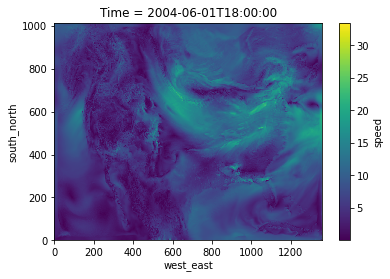

In [20]:
ds.speed.sel(Time='2004-06-01T18:00').isel(bottom_top=10).plot()

Grab U and V data for a number of time steps from the THREDDS RDA.

In [21]:
prefix = 'https://rda.ucar.edu/thredds/dodsC/files/g/ds612.0/PGW3D/2004/wrf3d_d01_PGW_'
list_of_files = []
for var in ('U', 'V'):
#    for day in range(1,15):
    for day in range(1,4):
        filename = prefix + var + f'_200406{day:02g}.nc'
        list_of_files.append(filename)

Create a multifile dataset.

In [22]:
with ProgressBar():
    ds = xr.open_mfdataset(list_of_files, parallel=True, chunks={'bottom_top': 10})

Calculate wind speed for entire dataset.

In [23]:
with ProgressBar():
    ds['U_unstaggered'] = unstagger(ds, 'U', 'west_east_stag', 'west_east')
    ds['V_unstaggered'] = unstagger(ds, 'V', 'south_north_stag', 'south_north')
    ds['speed'] = np.sqrt(ds.U_unstaggered**2 + ds.V_unstaggered**2)

Again, plot some wind speeds at a certain height and time.

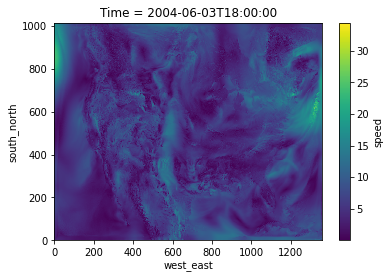

In [24]:
with ProgressBar():
    ds.speed.sel(Time='2004-06-03T18:00').isel(bottom_top=10).plot()

Mean winds over time.

In [25]:
mean_speed_lev5 = ds.speed.isel(bottom_top=5).mean(dim='Time')

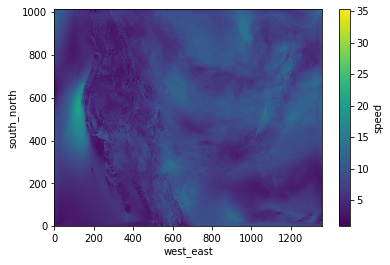

In [26]:
with ProgressBar():
    mean_speed_lev5.plot()

Let's calculate the Jetstream for our time range.

In [27]:
zonal_avg_mean_wind = ds.speed.mean(dim='west_east').mean(dim='Time')
zonal_avg_mean_wind

<xarray.DataArray 'speed' (bottom_top: 50, south_north: 1015)>
dask.array<mean_agg-aggregate, shape=(50, 1015), dtype=float32, chunksize=(10, 1015), chunktype=numpy.ndarray>
Dimensions without coordinates: bottom_top, south_north

Let's plot the Jetstream

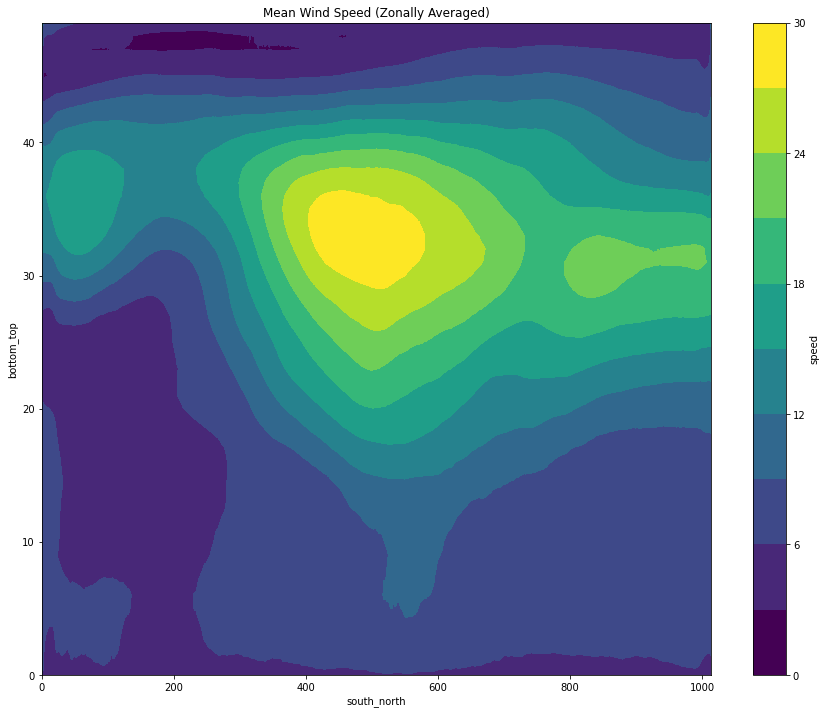

In [28]:
fig, ax = plt.subplots(figsize=(15,12))
zonal_avg_mean_wind.plot.contourf(ax=ax, levels=10)
ax.set_title('Mean Wind Speed (Zonally Averaged)')
plt.show()

How long did it take for the notebook to run?

In [29]:
time = time.time() - time0 
time

294.51585578918457

Don't forget to shut down your cluster.

In [30]:
c = gateway.connect(cluster.name)
c.shutdown()

Stop cell execution. Trying to programmatically shutdown kernel. This snippet does not seem work. If kernel is left running, you will see a number of error messages after a while. 

In [31]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

raise StopExecution

## Future work

- Experiment with cores, chunking strategies, etc.
- Experiment with different data stores. Current notebook will probably quickly be I/O bound.